# Cardiomyocyte Content Prediction

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## Introduction

Stem cell-derived cardyomyocytes (CM) have great potential for ischemic heart disease treatment. For their in-vitro production, hPSC (human pluripotent stem cells) must differentiate into hPSC-CM. 

*Threshold for classification is CM content >= 90 is sufficient and < 90 is insufficient (add to this later with source from paper)

### Main questions:
#### Can the sufficiency of CM content be accurately predicted?
#### Which features are most influential in high CM content?

In [40]:
# Importing data
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data_corrected.csv')
# Ensuring both datasets have same number of features
assert len(train_df.columns) == len(test_df.columns)
# Combining both datasets
data = pd.concat([train_df, test_df], ignore_index=True)

In [41]:
# Adding sufficiency column to data; CM content >= 90 is sufficinet; < 90 is insufficient
data["CM Content Sufficiency"] = 0
# 1 is sufficient, 0 is insufficient
for i in data.index:
    if data.loc[i, "dd10 CM Content"] >= 90:
        data.loc[i, "CM Content Sufficiency"] = 1
    else:
        data.loc[i, "CM Content Sufficiency"] = 0

In [42]:
# The dd10 CM Content column is no longer needed
data.drop("dd10 CM Content", axis=1, inplace=True)

#### New train and test sets will be made later to ensure a random split

## Data Cleaning

After visual inspection, the "DO concentration/cell count dd7" and "DO gradient/cell count dd7" columns in the test file did not have proper references to the cell count cells resulting in #ref errors. This has been fixed in the test excel file and converted back to csv.

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 103 entries, dd0 Cell Density to CM Content Sufficiency
dtypes: float64(102), int64(1)
memory usage: 48.4 KB


In [44]:
data.isna().sum().sum()

0

There are now no missing values in the dataset. All data types are numerical (float64 or int64).

## Feature Selection and Cross Validation

Before feature selection, the data will be split into train and test sets. This is done before feature selection to avoid picking features based on test (unseen) data

In [45]:
# Dividing data into X and y sets and splitting into train and test sets
from sklearn.model_selection import train_test_split
X = data.drop('CM Content Sufficiency', axis=1)
y = data['CM Content Sufficiency']
# The stratify argument ensures the proportion of each class in the train and test sets is reflective of the
# original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=25)

We have 102 features and only 60 observations. The number of features needs to be dramatically reduced to avoid
overfitting. With a large number of features compared to observations, the model will fit the noise in the training set leading to poor generalization.

The recursive feature elimination technique will be combined with cross validation using Scikit learn's RFECV. Recursive feature elimination iteratively considers less and less features by fitting the model at each step and discarding the least important ones.

In cross-validation (cv), the training set is further split into n subsets. The model is then trained on a fraction of each subset and evaluated on the remaining fraction. This is done n times for each subset. The cv performance is the average evaluated performance across each of the subsets.

Combining rfe and cv allows reducing the risk of overfitting (thanks to cv) while reliably identifying the important features. Cv helps make the feature selection task more robust, as the selected features have proven to be important across different subsets of the data.

In [46]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
lg = LogisticRegression(solver='liblinear')
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=25)
rfecv = RFECV(lg, cv=kf, scoring='recall')
rfecv.fit(X_train, y_train)
rfecv.n_features_
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 9


In [60]:
rfecv.cv_results_["mean_test_score"].mean()

0.3026143790849673

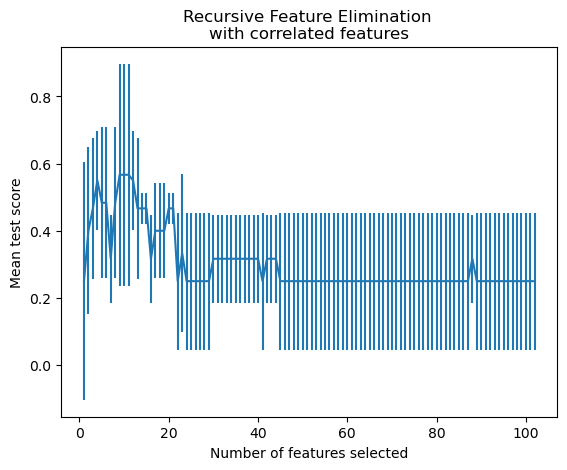

In [47]:
# Visualizing model performance as number of features changes
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [48]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 42 entries, 57 to 17
Series name: CM Content Sufficiency
Non-Null Count  Dtype
--------------  -----
42 non-null     int64
dtypes: int64(1)
memory usage: 672.0 bytes


In [49]:
X_train

,dd0 Cell Density,dd0-dd1 Cell Density Gradient,dd1 Cell Density,dd1-dd2 Cell Density Gradient,dd2 Cell Density,dd2-dd3 Cell Density Gradient,dd3 Cell Density,dd3-dd5 Cell Density Gradient,dd5 Cell Density,dd5-dd7 Cell Density Gradient,...,dd0 Lactate Concentration,dd1 Lactate Concentration,dd3 Lactate Concentration,dd5 Lactate Concentration,dd7 Lactate Concentration,dd0 Glucose Concentration,dd1 Glucose Concentration,dd3 Glucose Concentration,dd5 Glucose Concentration,dd7 Glucose Concentration
57,0.710,0.183099,0.8400,1.190476,1.840000,-0.130435,1.6000,0.262500,2.020,0.232673,...,12.1000,11.500000,17.000000,11.200000,9.700000,10.8000,5.600000,0.900000,4.400000,5.100000
41,0.470,0.617021,0.7600,0.710526,1.300000,0.923077,2.5000,-0.208000,1.980,-0.025253,...,13.9500,12.350000,16.380000,14.985000,11.120000,9.3700,4.535000,0.255000,1.940000,3.065000
56,0.625,0.200000,0.7500,1.160000,1.620000,0.407407,2.2800,0.197368,2.730,0.227106,...,12.7000,10.800000,16.700000,14.100000,15.700000,10.7000,5.400000,0.900000,2.100000,0.000000
11,1.090,-0.233945,0.8350,0.694611,1.415000,0.653710,2.3400,-0.038462,2.250,-0.471111,...,15.0300,11.255000,16.150000,14.685000,12.265000,8.9900,5.675000,1.175000,2.060000,2.870000
20,0.590,0.290339,0.7613,0.523709,1.160000,0.275862,1.4800,0.533784,2.270,-0.497797,...,14.0650,19.075000,18.015000,20.375000,20.590000,9.3383,3.000000,0.000000,1.260000,0.570000
28,1.120,-0.250000,0.8400,0.324405,1.112500,-0.101124,1.0000,0.160000,1.160,-0.144394,...,13.0725,14.695000,15.765000,17.575000,16.165000,8.6925,4.090000,0.000000,2.075000,0.000000
37,0.630,0.079365,0.6800,0.911765,1.300000,-0.030769,1.2600,0.000000,1.260,0.134921,...,14.8800,11.095000,16.405000,15.085000,13.175000,10.2575,5.200000,1.165000,2.430000,2.085000
14,0.890,0.005618,0.8950,0.413408,1.265000,0.754941,2.2200,0.121622,2.490,-0.363454,...,15.2450,11.050000,14.050000,14.325000,12.600000,9.0475,6.100000,1.540000,1.325000,1.615000
52,0.780,0.500000,1.1700,0.623932,1.900000,0.184211,2.2500,-0.062222,2.110,-0.142180,...,13.7000,13.800000,16.800000,15.600000,16.400000,9.7000,4.100000,0.000000,2.500000,0.700000
7,1.185,-0.755274,0.2900,0.190070,0.345120,4.128648,1.7700,-0.401130,1.060,-0.023585,...,12.3775,11.500000,13.375000,18.930000,14.225000,7.1350,0.700000,0.487500,0.000000,1.765000


In [50]:
lg = LogisticRegression(solver='liblinear')
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=25)
rfecv = RFECV(lg, cv=kf, scoring='recall')
rfecv.fit(X_train, y_train)
rfecv.n_features_
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 9


In [51]:
# Try with random forest instead
from sklearn.ensemble import RandomForestClassifier
kf_rf = StratifiedKFold(n_splits=3, shuffle=True, random_state=65)
rf = RandomForestClassifier()
rfecv_rf = RFECV(rf, cv=kf_rf, scoring='accuracy')
rfecv_rf.fit(X_train, y_train)
rfecv_rf.n_features_
print(f"Optimal number of features: {rfecv_rf.n_features_}")

Optimal number of features: 25


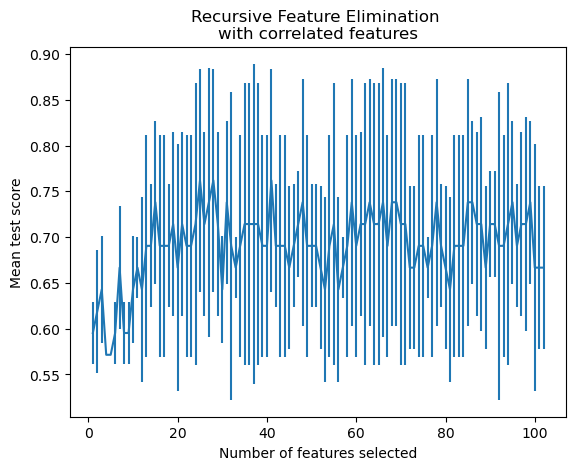

In [52]:
# Visualizing model performance as number of features changes
n_scores_rf = len(rfecv_rf.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
plt.errorbar(
    range(1, n_scores_rf + 1),
    rfecv_rf.cv_results_["mean_test_score"],
    yerr=rfecv_rf.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## Using their train and test sets

In [53]:
# Adding sufficiency column to data; CM content >= 90 is sufficinet; < 90 is insufficient
train_df["CM Content Sufficiency"] = 0
test_df["CM Content Sufficiency"] = 0
dfs = [train_df, test_df]
# 1 is sufficient, 0 is insufficient
for df in dfs:
    for i in df.index:
        if df.loc[i, "dd10 CM Content"] >= 90:
            df.loc[i, "CM Content Sufficiency"] = 1
        else:
            df.loc[i, "CM Content Sufficiency"] = 0
    # dd10 CM Content column is no longer needed
    df.drop("dd10 CM Content", axis=1, inplace=True)

In [54]:
prop = len(test_df[test_df["CM Content Sufficiency"] == 1]) / len(test_df)
prop

0.2777777777777778

In [55]:
prop_tr = len(train_df[train_df["CM Content Sufficiency"] == 1]) / len(train_df)
prop_tr

0.3333333333333333

y is not stratified properly between their sets

In [56]:
X_train_orig = train_df.drop("CM Content Sufficiency", axis=1).values
y_train_orig = train_df["CM Content Sufficiency"].values
X_test_orig = test_df.drop("CM Content Sufficiency", axis=1).values
y_test_orig = test_df["CM Content Sufficiency"].values

In [57]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
kf_orig = StratifiedKFold(n_splits=2, shuffle=True, random_state=150)
rf_orig = RandomForestClassifier(n_estimators=5)
rfecv_orig = RFECV(rf_orig, cv=kf_orig, scoring='accuracy')
rfecv_orig = rfecv_orig.fit(X_train_orig, y_train_orig)
rfecv_orig.n_features_
print(f"Optimal number of features: {rfecv_orig.n_features_}")

Optimal number of features: 10


In [58]:
rfecv_orig.cv_results_["mean_test_score"].mean()

0.6265172735760971

In [63]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier()
cv_loo = LeaveOneOut()
scores_loo = cross_val_score(model, X_train_orig, y_train_orig, scoring='accuracy', cv=cv_loo, n_jobs=-1)
scores_loo.mean()

0.7142857142857143

In [86]:
model.fit(X_train_orig, y_train_orig)
feature_importances = model.feature_importances_
X_train_orig_df = train_df.drop("CM Content Sufficiency", axis=1)
feature_names = X_train_orig_df.columns.values

In [90]:
feat_import_df = pd.DataFrame({'feature_names': feature_names, 'feature_importances': feature_importances})
feat_import_df.sort_values(by=['feature_importances'], inplace=True, ascending=False)

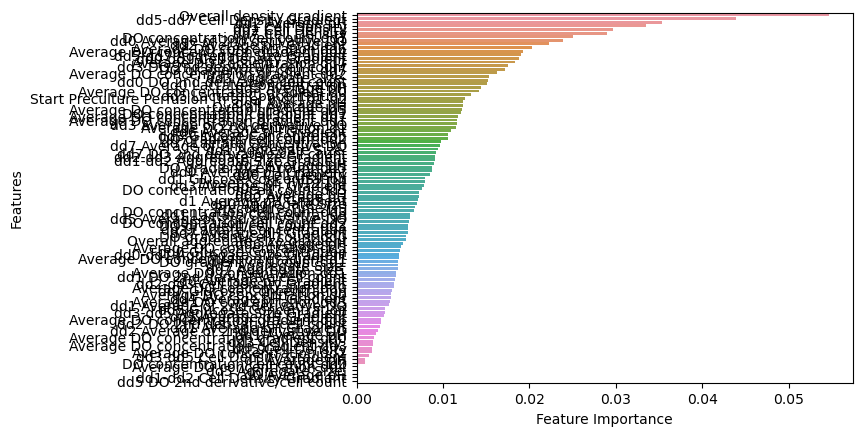

In [91]:
sns.barplot(x=feat_import_df['feature_importances'], y=feat_import_df['feature_names'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

In [92]:
feat_import_df

,feature_names,feature_importances
70,Overall density gradient,0.054687
9,dd5-dd7 Cell Density Gradient,0.043920
80,dd2 Average pH,0.035319
2,dd1 Cell Density,0.033453
4,dd2 Cell Density,0.029684
...,...,...
31,Average DO concentration dd4,0.000000
19,dd5 Aggregate Size,0.000000
72,d0 Average pH,0.000000
3,dd1-dd2 Cell Density Gradient,0.000000


In [96]:
# Optimizing hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
RF = RandomForestClassifier()
params_rf={'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2', None], 'max_depth': [10, 50, 100]}
rf_randomcv = RandomizedSearchCV(RF, params_rf, n_iter=20, cv=2, random_state=33, n_jobs=-1)
rf_randomcv.fit(X_train_orig, y_train_orig)

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 50, 100],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [10, 100, 1000]},
                   random_state=33)

In [97]:
rf_randomcv.best_params_

{'n_estimators': 1000, 'max_features': None, 'max_depth': 10}

In [100]:
RF_2 = RandomForestClassifier()
params_rf={'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2', None], 'max_depth': [10, 50, 100]}
rf_gridcv = GridSearchCV(RF_2, params_rf, cv=2, n_jobs=-1)
rf_gridcv.fit(X_train_orig, y_train_orig)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 50, 100],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 100, 1000]})

In [104]:
rf_gridcv.best_params_

{'max_depth': 50, 'max_features': 'log2', 'n_estimators': 10}

In [105]:
rf_gridcv.best_score_

0.6666666666666667